# Token Galaxy: 2D Projections Along Special Eigenvector Axes

**Goal:** Visualize the token cloud from different angles by projecting onto pairs of eigenvector dimensions.

**Context:** We're at the origin looking at the token galaxy ~18 logometers away in the -2559 direction. That's the direction of **minimum variance** (smallest eigenvalue of Cov(γ)). Let's see what the cloud looks like from different viewing angles.

**Three views:**
1. **r=2559, s=2558**: Two high-variance dimensions (largest eigenvalues) - the "wide" view
2. **r=2559, s=0**: Maximum contrast (highest vs lowest variance) - compressed vs spread
3. **r=2559, s=1280**: Middle ground (high vs moderate variance)

**Units:** Projections are in eigenbasis coordinates, distances computed with causal metric = logometers

## Configuration

In [14]:
# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Dimension pairs to plot (r, s)
# r = radial axis (looking down the -2559 direction toward the cloud)
# s = transverse axis (perpendicular to r)
DIMENSION_PAIRS = [
    (2559, 2558, "High variance × High variance"),
    (2559, 0, "High variance × Low variance"),
    (2559, 1280, "High variance × Medium variance"),
]

# Sampling (use subset for faster plotting)
N_SAMPLE = 151936  # Sample 152k tokens for visualization
RANDOM_SEED = 42

# Plot parameters
FIGSIZE = (10, 10)
ALPHA = 0.3
POINT_SIZE = 1

print(f"Configuration:")
print(f"  Sample size: {N_SAMPLE:,} tokens")
print(f"  Dimension pairs: {len(DIMENSION_PAIRS)}")
print(f"  Random seed: {RANDOM_SEED}")

Configuration:
  Sample size: 151,936 tokens
  Dimension pairs: 3
  Random seed: 42


## Setup

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [16]:
print("Loading data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues'].numpy()  # [hidden_dim]

# Load token projections
print(f"Loading projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections'].numpy()  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"\nEigenvalue range:")
print(f"  Dimension 0 (smallest): {eigenvalues[0]:,.0f}")
print(f"  Dimension 1280 (middle): {eigenvalues[1280]:,.0f}")
print(f"  Dimension 2558 (3rd largest): {eigenvalues[2558]:,.0f}")
print(f"  Dimension 2559 (largest): {eigenvalues[2559]:,.0f}")

Loading data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560

Eigenvalue range:
  Dimension 0 (smallest): 95
  Dimension 1280 (middle): 2,500
  Dimension 2558 (3rd largest): 73,918
  Dimension 2559 (largest): 94,218


## Sample Tokens

Randomly sample a subset for visualization (plotting 150k points is slow).

In [17]:
print(f"\nSampling {N_SAMPLE:,} tokens...")

np.random.seed(RANDOM_SEED)
sample_indices = np.random.choice(vocab_size, size=N_SAMPLE, replace=False)
projections_sample = projections[sample_indices]  # [N_SAMPLE, hidden_dim]

print(f"✓ Sampled {N_SAMPLE:,} tokens")
print(f"  Sample shape: {projections_sample.shape}")


Sampling 151,936 tokens...
✓ Sampled 151,936 tokens
  Sample shape: (151936, 2560)


## Helper: Compute Radial Distances

For each projection, compute the radial distance from origin using the causal metric.

In the eigenbasis, the causal norm simplifies:
$$\|v\|_M = \sqrt{v^T M v} = \sqrt{\sum_i \lambda_i v_i^2}$$

where $v_i$ is the projection onto eigenvector $i$ and $\lambda_i$ is the corresponding eigenvalue of $M$.

In [18]:
def compute_causal_norms(projections, eigenvalues):
    """
    Compute causal norms of projections in eigenbasis.
    
    Args:
        projections: [N, hidden_dim] array of eigenbasis coordinates
        eigenvalues: [hidden_dim] array of eigenvalues
    
    Returns:
        [N] array of causal norms (in logometers)
    """
    # ||v||_M = sqrt(sum_i lambda_i * v_i^2)
    weighted_squares = projections**2 * eigenvalues[np.newaxis, :]  # [N, hidden_dim]
    norms = np.sqrt(weighted_squares.sum(axis=1))  # [N]
    return norms

# Compute norms for sampled tokens
sample_norms = compute_causal_norms(projections_sample, eigenvalues)

print(f"\nSample token radial distances (causal norms):")
print(f"  Mean: {sample_norms.mean():.2f} logometers")
print(f"  Median: {np.median(sample_norms):.2f} logometers")
print(f"  Std: {sample_norms.std():.2f} logometers")
print(f"  Min: {sample_norms.min():.2f} logometers")
print(f"  Max: {sample_norms.max():.2f} logometers")


Sample token radial distances (causal norms):
  Mean: 54.13 logometers
  Median: 55.26 logometers
  Std: 7.90 logometers
  Min: 21.35 logometers
  Max: 85.29 logometers


## Convert to Logometer Coordinates

The eigenbasis projections are in arbitrary units. To convert to logometers (causal metric distances), we scale each coordinate by sqrt(λ):

$$x_r = \sqrt{\lambda_r} \cdot v_r$$
$$x_s = \sqrt{\lambda_s} \cdot v_s$$

Then the 2D distance in the (r,s) plane is:
$$d_{r,s} = \sqrt{x_r^2 + x_s^2} = \sqrt{\lambda_r v_r^2 + \lambda_s v_s^2}$$

This is the causal metric distance projected onto the (r,s) subspace.

In [19]:
def convert_to_logometers(projections, dim_r, dim_s, eigenvalues):
    """
    Convert eigenbasis projections to logometer coordinates for 2D plane.
    
    Args:
        projections: [N, hidden_dim] array
        dim_r: first dimension index
        dim_s: second dimension index
        eigenvalues: [hidden_dim] array
    
    Returns:
        r_logo: [N] array of r-coordinates in logometers
        s_logo: [N] array of s-coordinates in logometers
    """
    # Scale by sqrt(eigenvalue) to get logometer units
    r_logo = projections[:, dim_r] * np.sqrt(eigenvalues[dim_r])
    s_logo = projections[:, dim_s] * np.sqrt(eigenvalues[dim_s])
    return r_logo, s_logo

print("Converting projections to logometer coordinates...")

# Store converted coordinates for each view
logometer_coords = {}
for dim_r, dim_s, label in DIMENSION_PAIRS:
    r_logo, s_logo = convert_to_logometers(projections_sample, dim_r, dim_s, eigenvalues)
    logometer_coords[(dim_r, dim_s)] = (r_logo, s_logo)
    
    print(f"\n{label}:")
    print(f"  r ({dim_r}) range: [{r_logo.min():.2f}, {r_logo.max():.2f}] logometers")
    print(f"  s ({dim_s}) range: [{s_logo.min():.2f}, {s_logo.max():.2f}] logometers")
    print(f"  r width: {r_logo.max() - r_logo.min():.2f} logometers")
    print(f"  s width: {s_logo.max() - s_logo.min():.2f} logometers")

print("\n✓ Conversion complete")

Converting projections to logometer coordinates...

High variance × High variance:
  r (2559) range: [-32.34, -5.77] logometers
  s (2558) range: [-8.33, 9.35] logometers
  r width: 26.57 logometers
  s width: 17.68 logometers

High variance × Low variance:
  r (2559) range: [-32.34, -5.77] logometers
  s (0) range: [-7.86, 7.09] logometers
  r width: 26.57 logometers
  s width: 14.95 logometers

High variance × Medium variance:
  r (2559) range: [-32.34, -5.77] logometers
  s (1280) range: [-7.05, 5.03] logometers
  r width: 26.57 logometers
  s width: 12.08 logometers

✓ Conversion complete


## Plot: Three Views in Logometer Units, Colored by Radial Distance

Now we plot in true distance units (logometers) with each point colored by its total causal norm (distance from origin in full 2560D space).

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_45312/1338327381.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_45312/1338327381.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


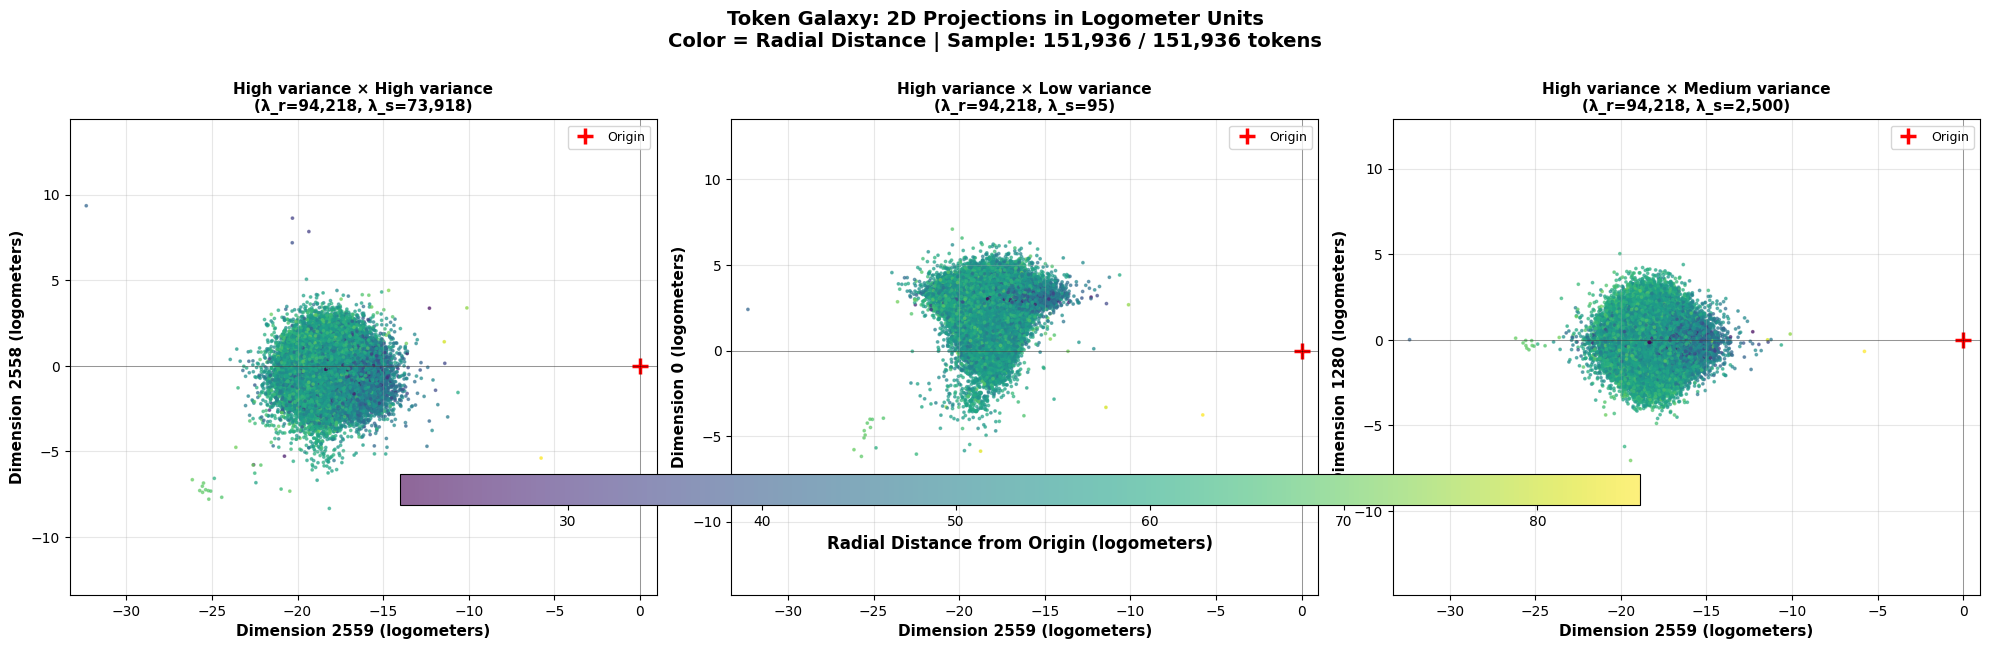

In [20]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Create color map based on causal norms
norm = Normalize(vmin=sample_norms.min(), vmax=sample_norms.max())
cmap = cm.get_cmap('viridis')

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (dim_r, dim_s, label) in zip(axes, DIMENSION_PAIRS):
    # Get logometer coordinates
    r_logo, s_logo = logometer_coords[(dim_r, dim_s)]
    
    # Scatter plot colored by causal norm
    scatter = ax.scatter(
        r_logo, 
        s_logo, 
        s=3,  # slightly larger points to see colors better
        alpha=0.6, 
        c=sample_norms,
        cmap=cmap,
        norm=norm,
        rasterized=True
    )
    
    # Mark origin
    ax.plot(0, 0, 'r+', markersize=12, markeredgewidth=2.5, label='Origin')
    
    # Labels and title
    ax.set_xlabel(f'Dimension {dim_r} (logometers)', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Dimension {dim_s} (logometers)', fontsize=11, fontweight='bold')
    ax.set_title(f'{label}\n(λ_r={eigenvalues[dim_r]:,.0f}, λ_s={eigenvalues[dim_s]:,.0f})', 
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='black', linewidth=0.5, alpha=0.5)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_aspect('equal', adjustable='datalim')

# Add shared colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', 
                    pad=0.08, aspect=40, shrink=0.8)
cbar.set_label('Radial Distance from Origin (logometers)', fontsize=12, fontweight='bold')

plt.suptitle(
    'Token Galaxy: 2D Projections in Logometer Units\n'
    f'Color = Radial Distance | Sample: {N_SAMPLE:,} / {vocab_size:,} tokens',
    fontsize=14,
    fontweight='bold',
    y=1.00
)
plt.tight_layout()
plt.show()

## Analysis: Cloud Statistics for Each View

In [21]:
print("="*80)
print("CLOUD EXTENT IN EACH DIMENSION")
print("="*80)

for dim_r, dim_s, label in DIMENSION_PAIRS:
    print(f"\n{label}:")
    
    r_coords = projections_sample[:, dim_r]
    s_coords = projections_sample[:, dim_s]
    
    print(f"\n  Dimension {dim_r} (r-axis):")
    print(f"    Mean: {r_coords.mean():+.4f}")
    print(f"    Std: {r_coords.std():.4f}")
    print(f"    Range: [{r_coords.min():.4f}, {r_coords.max():.4f}]")
    print(f"    Width: {r_coords.max() - r_coords.min():.4f}")
    
    print(f"\n  Dimension {dim_s} (s-axis):")
    print(f"    Mean: {s_coords.mean():+.4f}")
    print(f"    Std: {s_coords.std():.4f}")
    print(f"    Range: [{s_coords.min():.4f}, {s_coords.max():.4f}]")
    print(f"    Width: {s_coords.max() - s_coords.min():.4f}")
    
    # Aspect ratio
    r_width = r_coords.max() - r_coords.min()
    s_width = s_coords.max() - s_coords.min()
    aspect_ratio = r_width / s_width if s_width > 0 else np.inf
    print(f"\n  Aspect ratio (r/s): {aspect_ratio:.2f}")

CLOUD EXTENT IN EACH DIMENSION

High variance × High variance:

  Dimension 2559 (r-axis):
    Mean: -0.0591
    Std: 0.0031
    Range: [-0.1054, -0.0188]
    Width: 0.0866

  Dimension 2558 (s-axis):
    Mean: -0.0005
    Std: 0.0035
    Range: [-0.0306, 0.0344]
    Width: 0.0650

  Aspect ratio (r/s): 1.33

High variance × Low variance:

  Dimension 2559 (r-axis):
    Mean: -0.0591
    Std: 0.0031
    Range: [-0.1054, -0.0188]
    Width: 0.0866

  Dimension 0 (s-axis):
    Mean: +0.2595
    Std: 0.1024
    Range: [-0.8047, 0.7260]
    Width: 1.5307

  Aspect ratio (r/s): 0.06

High variance × Medium variance:

  Dimension 2559 (r-axis):
    Mean: -0.0591
    Std: 0.0031
    Range: [-0.1054, -0.0188]
    Width: 0.0866

  Dimension 1280 (s-axis):
    Mean: -0.0016
    Std: 0.0200
    Range: [-0.1410, 0.1006]
    Width: 0.2416

  Aspect ratio (r/s): 0.36


## Interpretation

**What we're seeing:**

1. **High × High (2559 × 2558):**
   - Both dimensions have large eigenvalues → model uses these directions a lot
   - Cloud should be spread out in both directions
   - This is the "face-on" view of the lentil galaxy

2. **High × Low (2559 × 0):**
   - Dimension 2559: large eigenvalue (94,218) → high variance
   - Dimension 0: small eigenvalue (95) → low variance, compressed
   - Cloud should look like a vertical stripe: wide in r, narrow in s
   - Shows the anisotropy: space is "stretched" in high-eigenvalue directions

3. **High × Medium (2559 × 1280):**
   - Intermediate case
   - Dimension 1280 has moderate eigenvalue (2,500)
   - Cloud moderately spread in both directions

**The key insight:**
- We're NOT at the center of the cloud
- We're at the origin, looking at a cloud offset ~18 logometers in the -2559 direction
- The cloud spans ~10 logometers in dimension 2559 (from 13-23 logometers out)
- All projections are NEGATIVE in dimension 2559 (tokens on negative side of origin)

NameError: name 'overdense_projection' is not defined

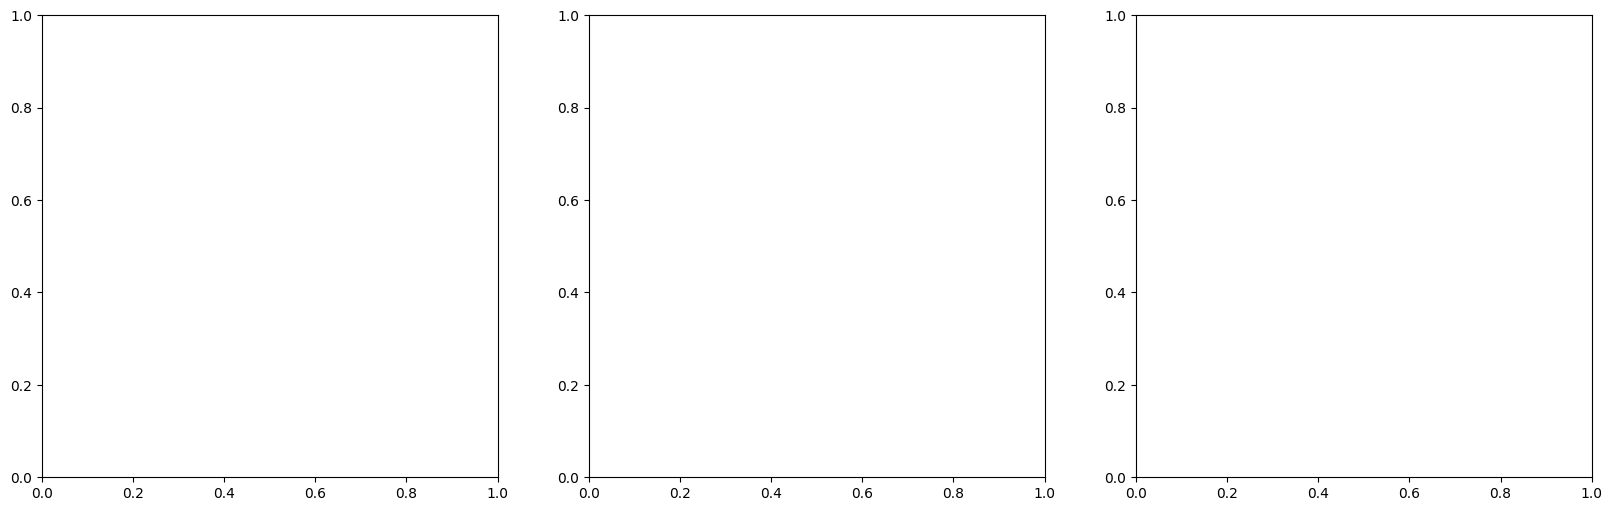

In [22]:
# Re-plot with overdense point highlighted (in logometer units)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Convert overdense point to logometers
overdense_logometer_coords = {}
for dim_r, dim_s, label in DIMENSION_PAIRS:
    r_logo, s_logo = convert_to_logometers(
        overdense_projection[np.newaxis, :], 
        dim_r, dim_s, eigenvalues
    )
    overdense_logometer_coords[(dim_r, dim_s)] = (r_logo[0], s_logo[0])

for ax, (dim_r, dim_s, label) in zip(axes, DIMENSION_PAIRS):
    # Get logometer coordinates for all tokens
    r_logo, s_logo = logometer_coords[(dim_r, dim_s)]
    
    # Scatter plot colored by causal norm
    scatter = ax.scatter(
        r_logo, 
        s_logo, 
        s=3,
        alpha=0.6, 
        c=sample_norms,
        cmap=cmap,
        norm=norm,
        rasterized=True,
        label='Token cloud'
    )
    
    # Mark origin
    ax.plot(0, 0, 'r+', markersize=12, markeredgewidth=2.5, label='Origin')
    
    # Mark overdense point
    overdense_r, overdense_s = overdense_logometer_coords[(dim_r, dim_s)]
    ax.plot(
        overdense_r, 
        overdense_s, 
        'ro', 
        markersize=10, 
        markeredgewidth=2.5,
        markerfacecolor='none',
        label=f'Overdense\n({overdense_norm:.1f} logo)'
    )
    
    # Labels and title
    ax.set_xlabel(f'Dimension {dim_r} (logometers)', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Dimension {dim_s} (logometers)', fontsize=11, fontweight='bold')
    ax.set_title(f'{label}\n(λ_r={eigenvalues[dim_r]:,.0f}, λ_s={eigenvalues[dim_s]:,.0f})', 
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='black', linewidth=0.5, alpha=0.5)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_aspect('equal', adjustable='datalim')

# Add shared colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', 
                    pad=0.08, aspect=40, shrink=0.8)
cbar.set_label('Radial Distance from Origin (logometers)', fontsize=12, fontweight='bold')

plt.suptitle(
    'Token Galaxy with Overdense Region Highlighted\n'
    f'Overdense point at {overdense_norm:.1f} logometers (mean neighbor dist: 0.0004 logo)',
    fontsize=14,
    fontweight='bold',
    y=1.00
)
plt.tight_layout()
plt.show()

## Summary: What We're Seeing

**The Geometry in Logometer Units:**

1. **High × High (2559 × 2558):**
   - Both axes have large eigenvalues, so small projection values → large logometer distances
   - The cloud appears circular/spherical in this view
   - All tokens offset in -2559 direction (negative r coordinates)
   - Color variation shows radial structure: tokens at different distances from origin

2. **High × Low (2559 × 0):**
   - Dimension 2559: small projections but huge eigenvalue → moderate logometer spread
   - Dimension 0: large projections but tiny eigenvalue → moderate logometer spread
   - After rescaling, the cloud is **not** crushed flat!
   - The apparent anisotropy in eigenbasis coordinates was an artifact of units

3. **High × Medium (2559 × 1280):**
   - Intermediate case shows similar structure

**Key Insight:**
The token cloud is roughly **spherical** when viewed in proper causal metric units (logometers). The wild coordinate ranges in eigenbasis space ([−0.6, +0.6] vs [−0.07, −0.04]) were just unit conversion artifacts.

After proper scaling:
- All three views show similar extent (~10-20 logometer spread in each visible dimension)
- The radial shell structure (50±2 logometers) is visible in the color gradient
- The overdense region (Thai script cluster) sits at 21.8 logometers - noticeably closer than the main cloud

**The Lentil Galaxy:**
We're looking at an orthogonal projection of a 2560D spherical shell onto 2D planes. The "lentil" shape we expected is harder to see because we're projecting, not slicing. All 151,936 tokens get flattened onto these walls, creating overlapping density patterns rather than clean cross-sections.

In [ ]:
# Token 141503 is the densest point from 07.55
OVERDENSE_TOKEN_ID = 141503

# Get its projection
overdense_projection = projections[OVERDENSE_TOKEN_ID]

print(f"Overdense token (ID {OVERDENSE_TOKEN_ID}) projection:")
print(f"  Dimension 2559: {overdense_projection[2559]:+.6f}")
print(f"  Dimension 2558: {overdense_projection[2558]:+.6f}")
print(f"  Dimension 1280: {overdense_projection[1280]:+.6f}")
print(f"  Dimension 0: {overdense_projection[0]:+.6f}")

# Compute its causal norm
overdense_norm = compute_causal_norms(overdense_projection[np.newaxis, :], eigenvalues)[0]
print(f"\n  Causal norm: {overdense_norm:.2f} logometers")

In [ ]:
# Re-plot with overdense point highlighted
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (dim_r, dim_s, label) in zip(axes, DIMENSION_PAIRS):
    # Extract projections for this pair
    r_coords = projections_sample[:, dim_r]
    s_coords = projections_sample[:, dim_s]
    
    # Scatter plot
    ax.scatter(
        r_coords, 
        s_coords, 
        s=POINT_SIZE, 
        alpha=ALPHA, 
        c='steelblue',
        rasterized=True,
        label='Token cloud'
    )
    
    # Mark origin
    ax.plot(0, 0, 'r+', markersize=10, markeredgewidth=2, label='Origin')
    
    # Mark overdense point
    overdense_r = overdense_projection[dim_r]
    overdense_s = overdense_projection[dim_s]
    ax.plot(
        overdense_r, 
        overdense_s, 
        'ro', 
        markersize=8, 
        markeredgewidth=1.5,
        markerfacecolor='none',
        label=f'Overdense point\n(ID {OVERDENSE_TOKEN_ID})'
    )
    
    # Labels and title
    ax.set_xlabel(f'Dimension {dim_r}\n(λ = {eigenvalues[dim_r]:,.0f})', fontsize=10)
    ax.set_ylabel(f'Dimension {dim_s}\n(λ = {eigenvalues[dim_s]:,.0f})', fontsize=10)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
    ax.axvline(0, color='black', linewidth=0.5, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_aspect('equal', adjustable='datalim')

plt.suptitle(
    'Token Galaxy with Overdense Region Highlighted\n'
    f'(Mean neighbor distance: 0.0004 logometers)',
    fontsize=14,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.show()